<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/Attention_Kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 Introduction to the Attention Operator

(Fayyaz Minhas)

## 🚀 Overview
Attention mechanisms are a **core concept in deep learning** that allow models to **focus on the most relevant information** dynamically. Instead of treating all input features equally, an attention mechanism computes **importance scores** between different input elements and uses them to weight the final representation.

In this tutorial, we introduce a **generalised attention mechanism** using a **toy example**: the **XOR function**, where each input consists of **two tokens** (e.g., `[0,1]` or `[1,1]`). We will:
1. **Compute associations** between tokens using a **pseudo kernel function**.
2. **Normalize the associations** using the **softmax function** to get **attention scores**.
3. **Use the attention scores** to compute a **new representation** of the input.

---

## 🧩 Input Representation
Each input consists of **two tokens**. For example, the input `[0,1]` can be considered as:
- **Token 1**: `0`
- **Token 2**: `1`

We first compute a **kernel function** that measures the **degree of association between these two tokens of the same input**.

---

## 🔢 Step 1: Computing the Kernel Matrix $k(x)$
For an input example $x=[x_1,x_2,...,x_{d_0}]^T$  composed of $d_0$ tokens ($d_0=2$ for the XOR problem), The **kernel matrix** $K(x)$ represents the **association** between tokens. It is a **$2 \times 2$ matrix**, where each entry $ K_{ij} $ represents **how similar token \( i \) is to token \( j \)**.

### **Two Approaches to Computing \( K \):**
1. **Non-trainable attention**:  
   One can compute the similarity using a linear kernel which is non-trainable:
   $$
   K(x) = x x^T
   $$
   This means:
   $$
   K_{ij}(x) = x_i x_j
   $$

2. **Learnable Kernel** (Neural Network Layers):  
   Instead of using a fixed formula, we learn \( K \) using a **trainable transformation** which is implemented as a neural network:
   $$
   K(x) = k(x; W_K)
   $$
   where $ W_K $ are learnable weights.


Note that the above "Kernel" function may not be symmetric or positive semidefinite and thus, in strict mathematical sense, is not a Mercer Kernel -- hence we can call it a "pseudo"-kernel function.

Also, note that the above formulation in which the kernel matrix computes degree of similarity between tokens of the same input is called **Self Attention**. However, we can also compute a **Cross Attention** kernel between tokens of two different representations $u$ and $v$ (e.g., modalities such as text and image) associated with the same example as $K(u,v)=K(u,v; W_K)$.  The dimensionality of $K(u,v)$ would be equal to $d_u \times d_v$ where $d_u$ and $d_v$ are the number of tokens in the two representations.

---

## 🔥 Step 2: Applying Softmax to Obtain Attention Scores
Once we compute the kernel matrix $K$, we normalize it to obtain **attention scores**.

We apply the **softmax function** row-wise:
$$
A_{ij}(x) = \frac{\exp(K_{ij}(x))}{\sum_{j'} \exp(K_{ij'}(x))}
$$
This ensures:
- **Each row of $A(x)$ sums to 1**.
- **Values are between 0 and 1**, making them interpretable as probabilities.

Thus, $A(x)$ (which is a matrix of size $2\times 2$) tells us **how much attention each token gives to every other token**. Note that the softmax function simply tells us which tokens are more associated with what other tokens based on the current representation.

---

## 🎭 Step 3: Computing the Value Matrix $V(x)$
Each token also has a **learnable transformation** (implemented as a neural network) that maps it to a $d$-dimensional latent space:
$$
V(x) = g(X; W_V)
$$
where $ W_V $ are learnable parameters.

$V(x)$ is a $2 \times d $ matrix, where:
- **Each row corresponds to a token**.
- **Each column corresponds to a learned feature**.

---

## 🛠️ Step 4: Computing the Final Representation $Z(x)$
The final **context-aware representation** of the input is obtained by **multiplying attention scores with the value matrix**:
$$
Z(x) = A(x)V(x)
$$
This means that each token's new representation is a **weighted sum** of all token values, with weights determined by the attention scores.

In the code below, we **flatten** $Z(x)$ and pass it through a 2-dimensional **projection layer** (which is used for visualisation only) to get a **final output**.

---

## 📝 Final Attention Mechanism Formula
Summarizing all steps:
0. **Input example** $x=[x_1,x_2,...,x_{d_0}]^T$  composed of $d_0$ tokens

1. Compute the **Kernel Matrix**:
   $$
   K(x) = k(x; W_K) \quad \text{or} \quad K(x) = x x^T
   $$

2. Compute the **Attention Scores Matrix** using softmax:
   $$
   A_{ij}(x) = \frac{\exp(K_{ij}(x))}{\sum_{j'} \exp(K(x)_{ij'})}
   $$

3. Compute the **Value Matrix**:
   $$
   V(x) = g(x; W_V)
   $$

4. Compute the **Attention Output**:
   $$
   Z(x) = A(x)V(x)
   $$

5. Compute the **Final Representation**: By applying different activation functions and flattening or pooling the output across tokens in $x$.

**Intuitively**, The attention mechanism learns to determine how much each token in an input sequence should influence every other token, adjusting these weightings through error minimization to create a more contextually informed representation of each token.

## 📝 Implementation in PyTorch
Now we will implement these steps in the code. We will pass the data through the attention mechanism and then flattent the output $Z(x)$ which is then passed to a single neuron with sigmoid activation to generate the final output. Note that we also use a randomly initialised linear layer to reduce the dimensionality of $Z(x)$ to two dimensions for visualisation of the latent representation being learned for different inputs.

Note that we implement a projection of the flattened version of $Z(x)$ to two dimensions for visualisation only.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the model
class XORAttentionModel(nn.Module):
    def __init__(self, d=4, kernel_type = 'learnable'):  # d is the latent dimension
        super(XORAttentionModel, self).__init__()

        self.d = d  # Latent dimension
        self.kernel_type = kernel_type  # Type of kernel: 'linear' or 'learnable'
        # Kernel transformation (produces a 2x2 matrix)
        self.kernel_layer = nn.Linear(2, 4)  # Maps 2 tokens to 4 values of the 2x2 kernel matrix between tokens

        # Value transformation (produces a 2xd matrix)
        self.value_layer = nn.Linear(2, 2 * d)  # Maps 2 tokens to 2*d values

        # New projection layer: projects 2d down to 2D for visualization
        self.projection_layer = nn.Linear(2 * d, 2)  # Maps [batch_size, 2d] → [batch_size, 2]
        self.projection_layer.weight.requires_grad = False #randomly initialised
        self.projection_layer.bias.requires_grad = False

        # Final output layer (maps projected 2D representation to scalar output)
        self.output_layer = nn.Linear(2*d, 1)

    def forward(self, x):
        batch_size = x.shape[0] # shape [batch_size, 2]
        if self.kernel_type == 'linear':
          K = torch.bmm(x.unsqueeze(2), x.unsqueeze(1))  # Computes XX^T
        elif self.kernel_type == 'learnable':
          # Learnable kernel K(X', X; W_K) -> reshaped to 2x2
          K = self.kernel_layer(x)  # Shape: [batch_size, 4]
          K = K.view(batch_size, 2, 2)  # Reshape to [batch_size, 2, 2]
        else:
          raise NotImplemented
        # Softmax over the last dimension (row-wise normalization) to give attention scores
        A = torch.softmax(K, dim=-1)  # Shape: [batch_size, 2, 2], A_{ij} = \frac{\exp(K_{ij})}{\sum_{k} \exp(K_{ik})}

        # A = K # directly without softmax for comparison
        # A = (A + A.transpose(1, 2)) / 2 #optionall make it symmetric

        # Learnable transformation V(X; W_V) -> reshaped to 2xd
        V = self.value_layer(x)  # Shape: [batch_size, 2*d]
        V = V.view(batch_size, 2, self.d)  # Reshape to [batch_size, 2, d]

        # Apply attention: Z = A * V
        Z = torch.bmm(A, V)  # Shape: [batch_size, 2, d]

        # Flatten the output to shape [batch_size, 2*d]
        Z = Z.view(batch_size, 2 * self.d)

        # Pass through the final output layer
        out = torch.sigmoid(self.output_layer(Z))  # Shape: [batch_size, 1]

        # Pass through the new projection layer to get a 2D representation
        Z_projected = self.projection_layer(Z)  # Shape: [batch_size, 2]

        return out, A, Z_projected  # Return attention matrix and 2D transformed representations

# Instantiate the model
model = XORAttentionModel(d=4, kernel_type = 'learnable')
# Training Data for XOR
X_train = torch.tensor([[0,0], [0,1], [1,0], [1,1]], dtype=torch.float32)
y_train = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)  # XOR labels

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss for XOR classification
optimizer = optim.Adam(model.parameters(), lr=0.01)


Epoch [0/100], Loss: 0.7256
Epoch [10/100], Loss: 0.6870
Epoch [20/100], Loss: 0.6577
Epoch [30/100], Loss: 0.6175
Epoch [40/100], Loss: 0.5519
Epoch [50/100], Loss: 0.4550
Epoch [60/100], Loss: 0.3371
Epoch [70/100], Loss: 0.2222
Epoch [80/100], Loss: 0.1340
Epoch [90/100], Loss: 0.0791


<ipython-input-8-78c6bd544911>:103: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


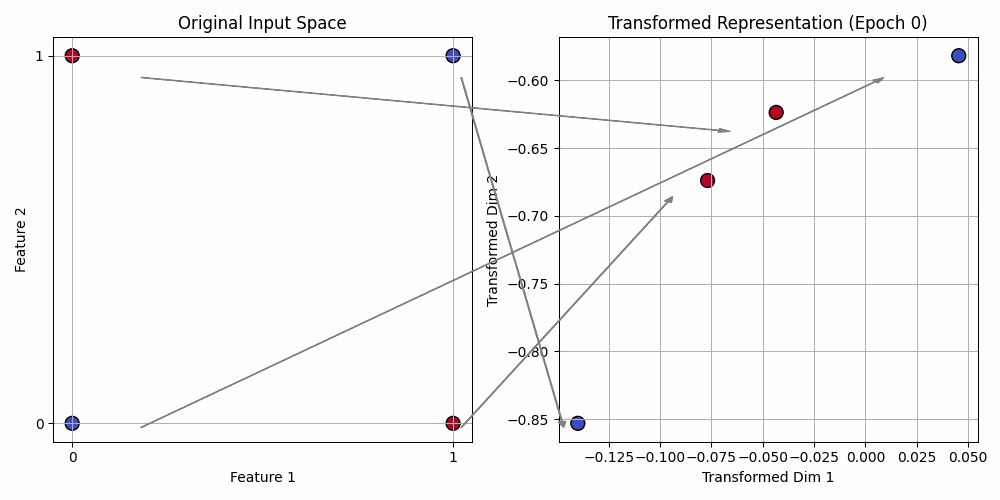

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import imageio
import os
from IPython.display import Image

# Create a directory to store images
os.makedirs("frames", exist_ok=True)
# Function to visualize transformation (can ignore)
def plot_transformed_representations_with_arrows(model, X_train, y_train, epoch):
    """
    Plots both the original and transformed representation of inputs,
    with **perfectly aligned** arrows between left and right plot.
    """
    with torch.no_grad():
        _, _, transformed_points = model(X_train)  # Get 2D representations

    # Convert to NumPy
    transformed_points = transformed_points.numpy()
    y_train = y_train.numpy().flatten()
    original_points = X_train.numpy()  # Keep the original input points

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Left plot: Original input space
    ax[0].scatter(original_points[:, 0], original_points[:, 1], c=y_train, cmap="coolwarm", s=100, edgecolors='k', label="Original Points")
    ax[0].set_title("Original Input Space")
    ax[0].set_xlabel("Feature 1")
    ax[0].set_ylabel("Feature 2")
    ax[0].set_xticks([0, 1])
    ax[0].set_yticks([0, 1])
    ax[0].grid(True)

    # Right plot: Transformed space
    ax[1].scatter(transformed_points[:, 0], transformed_points[:, 1], c=y_train, cmap="coolwarm", s=100, edgecolors='k', label="Transformed Points")
    ax[1].set_title(f"Transformed Representation (Epoch {epoch})")
    ax[1].set_xlabel("Transformed Dim 1")
    ax[1].set_ylabel("Transformed Dim 2")
    ax[1].grid(True)

    # **Final fix**: No gaps between arrows and points
    fig.canvas.draw()

    for i in range(len(original_points)):
        # Get original and transformed points in **display coordinates**
        orig_disp_coords = ax[0].transData.transform(original_points[i])
        trans_disp_coords = ax[1].transData.transform(transformed_points[i])

        # Convert back to **figure coordinates**
        orig_fig_coords = fig.transFigure.inverted().transform(orig_disp_coords)
        trans_fig_coords = fig.transFigure.inverted().transform(trans_disp_coords)

        # **FINAL FIX: No offset adjustments, just direct mapping**
        start_x, start_y = orig_fig_coords
        end_x, end_y = trans_fig_coords

        # Draw arrows using **FancyArrow** with **minimal head size** for precision
        arrow = patches.FancyArrow(
            start_x, start_y,
            end_x - start_x, end_y - start_y,
            transform=fig.transFigure, color='gray',
            linewidth=0.8, head_width=0.008, head_length=0.012, length_includes_head=True
        )
        fig.patches.append(arrow)

    plt.tight_layout()

    # Save frame as an image
    plt.savefig(f"frames/frame_{epoch:03d}.png")
    plt.close()

# Training Loop with GIF frame saving
epochs = 100
visualize = True
for epoch in range(epochs):
    if visualize:
      plot_transformed_representations_with_arrows(model, X_train, y_train, epoch)  # Save frame

    optimizer.zero_grad()

    # Forward pass
    outputs, _, _ = model(X_train)

    # Compute loss
    loss = criterion(outputs, y_train)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

if visualize:
  # Create GIF from saved frames
  images = []
  for i in range(epochs):
      filename = f"frames/frame_{i:03d}.png"
      images.append(imageio.imread(filename))

  imageio.mimsave("training_transformation.gif", images, fps=5)  # Save GIF

  # Display GIF in Colab
  from IPython.display import display
  display(Image(filename="training_transformation.gif"))


## Visualising Attention Weights

We now visualise attention weights between tokens for different input examples. What are your observations about these?

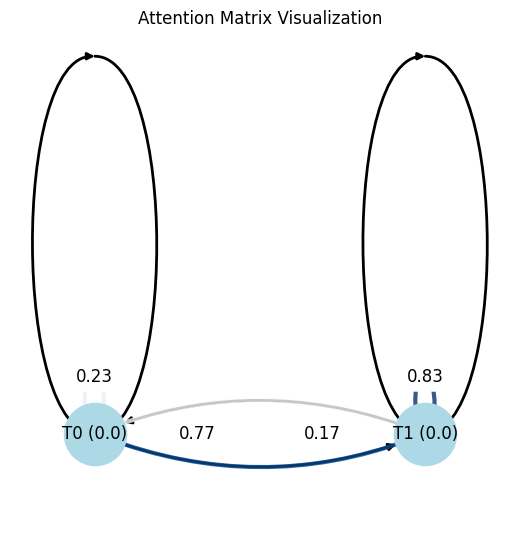

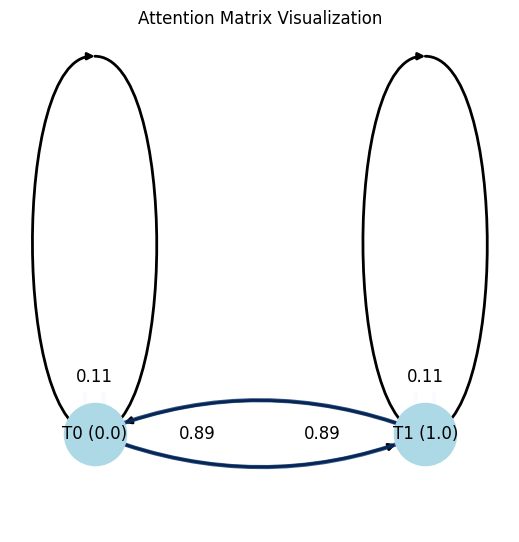

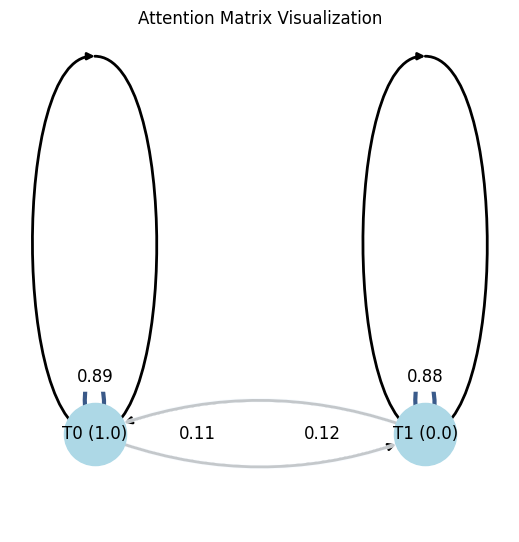

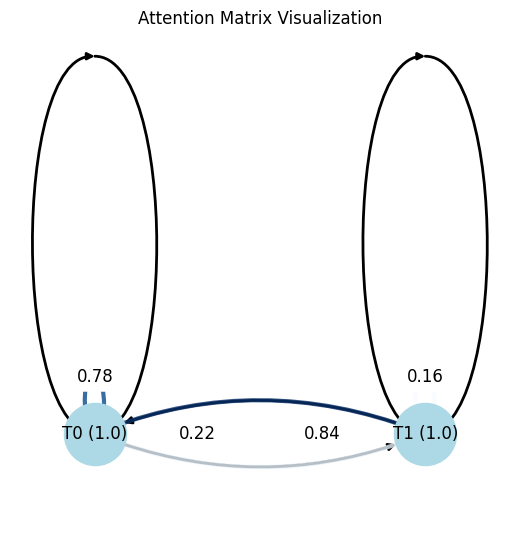

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_attention(A, input_tokens):
    """ Visualizes the attention matrix A using NetworkX with correctly labeled edges. """
    G = nx.DiGraph()

    # Define node labels based on input tokens
    node_labels = {0: f"T0 ({input_tokens[0]})", 1: f"T1 ({input_tokens[1]})"}

    # Add nodes (tokens)
    G.add_nodes_from([0, 1])

    # Extract attention weights and store edges
    edge_labels = {}
    edge_weights = []
    edges = []  # Store edges for correct order

    for i in range(2):
        for j in range(2):
            weight = A[i, j].item()
            edges.append((i, j))
            G.add_edge(i, j, weight=weight)
            edge_labels[(i, j)] = f"{weight:.2f}"
            edge_weights.append(weight)

    # Define positions for better layout
    pos = {0: (-1, 0), 1: (1, 0)}

    # Normalize weights for edge color intensity
    weights = np.array(edge_weights)
    min_w, max_w = weights.min(), weights.max()
    norm_weights = (weights - min_w) / (max_w - min_w + 1e-6)  # Avoid division by zero

    # Define edge colors using a colormap (darker = higher weight)
    edge_colors = [plt.cm.Blues(w) for w in norm_weights]

    plt.figure(figsize=(5, 5))

    # Draw nodes
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000, font_size=12,
            node_color='lightblue', edge_color='black', width=2, connectionstyle="arc3,rad=0.2")

    # Draw edges with correct coloring and curvature
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=3, alpha=0.8,
                           connectionstyle="arc3,rad=0.2")

    # Draw edge labels (correctly assigned)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, label_pos=0.3)

    plt.title("Attention Matrix Visualization")
    plt.show()

# Test input to visualize attention
test_input = torch.tensor([[0,0]], dtype=torch.float32)
_, attention_matrix, _ = model(test_input)

# Visualize the attention matrix for input [0,1]
visualize_attention(attention_matrix[0], test_input[0].tolist())


# Test input to visualize attention
test_input = torch.tensor([[0,1]], dtype=torch.float32)
_, attention_matrix, _ = model(test_input)
# Visualize the attention matrix for input [0,1]
visualize_attention(attention_matrix[0], test_input[0].tolist())

# Test input to visualize attention
test_input = torch.tensor([[1,0]], dtype=torch.float32)
_, attention_matrix, _ = model(test_input)
# Visualize the attention matrix for input [0,1]
visualize_attention(attention_matrix[0], test_input[0].tolist())

# Test input to visualize attention
test_input = torch.tensor([[1,1]], dtype=torch.float32)
_, attention_matrix, _ = model(test_input)
# Visualize the attention matrix for input [0,1]
visualize_attention(attention_matrix[0], test_input[0].tolist())

In [ ]:
attention_matrix

tensor([[[0.6853, 0.3147],
         [0.1240, 0.8760]]], grad_fn=<SoftmaxBackward0>)